# Tutorial 2: Analyzing Multiple Imaginal Discs

There are two ways to go about analyzing multiple eye discs in FlyEye:

 1. Load each disc separately using ``Disc.from_silhouette()``, align them using the ``flyeye.alignment`` module, then analyze and plot them each individually.

    **OR**
    
      
 2. Use flyeye's ``Experiment`` class to align, analyze, and plot multiple eye discs at the same time. This data structure is designed for managing multiple eye discs of the same type, so we recommend creating a separate ``Experiment`` instance for each imaging session, experimental condition, and genotype.

# Approach 1: Load and Align each disc independently

Load each disc using the ``Disc.from_silhouette()`` method:

In [1]:
from flyeye.data import Disc

# import each silhouette file separately
disc1 = Disc.from_silhouette('data/disc1.silhouette', normalization='ch0')
disc2 = Disc.from_silhouette('data/disc2.silhouette', normalization='ch0')
disc3 = Disc.from_silhouette('data/disc3.silhouette', normalization='ch0')

Flyeye's ``processing`` module offers several automated alignment tools. Alignment is done pairwise using the ``DiscAlignment`` object: each disc is shifted in time such that it is aligned with some other reference disc. The alignment is linear in the sense that we just add a constant time-offset to all measurements in the shifted disc (this equates to "shift Disc X by Y hours"). It doesn't matter which disc we select as the reference disc. 

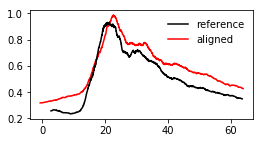

In [4]:
from flyeye.processing import DiscAlignment

# align disc 2 with disc 1
alignment = DiscAlignment(disc2, reference_disc=disc1, channel='ch2_normalized')

# plot the alignment (don't need to do this, just for demonstration)
alignment.plot_alignment(scatter=False)

# now we can get back a time-shifted copy of disc 2 that's aligned with disc 1
disc2_aligned = alignment.get_aligned_disc()

Putting it all together, if we have three discs we declare the first as the reference then we use ``processing.DiscAlignment()`` to shift the other two to align with the first one.

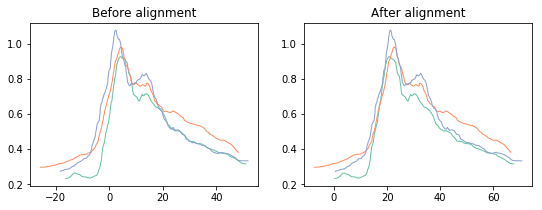

In [9]:
# align discs 2 and 3 with disc 1
disc1_aligned = DiscAlignment(disc1, disc1, channel='ch2_normalized').get_aligned_disc()
disc2_aligned = DiscAlignment(disc2, disc1, channel='ch2_normalized').get_aligned_disc()
disc3_aligned = DiscAlignment(disc3, disc1, channel='ch2_normalized').get_aligned_disc()

# plot the aligned discs side-by-side with the originals
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(9, 3))
ax0.set_title('Before alignment'), ax1.set_title('After alignment')

# plot discs before alignment
_ = disc1.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax0, line_kw={'color':plt.cm.Set2(0)})
_ = disc2.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax0, line_kw={'color':plt.cm.Set2(1)})
_ = disc3.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax0, line_kw={'color':plt.cm.Set2(2)})

# plot discs after alignment
_ = disc1_aligned.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax1, line_kw={'color':plt.cm.Set2(0)})
_ = disc2_aligned.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax1, line_kw={'color':plt.cm.Set2(1)})
_ = disc3_aligned.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax1, line_kw={'color':plt.cm.Set2(2)})

## Things to keep in mind

Under the hood, the time-offset between a pair of discs is calculated by maximizing the cross correlation of a user-specified fluorescence channel between all progenitors in those two discs. You can specify the reference channel using the ``channel`` argument. You can also use ``DiscAlignment.plot_scores()`` to assess the alignment. The black line is the crosscorrelation as a function of the time-offset (lag) between the aligned disc and the refernce disc. The red is the maximum, e.g. the time-offset at which the two discs are optimally aligned.

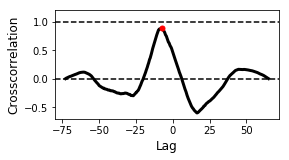

In [10]:
alignment.plot_scores()

For the alignment to work, the reference channel needs to have an appreciable trend to align between the discs. So using DAPI is a bad idea, because there's no trend to align between the discs. This is obvious when you look at the cross correlation in DAPI, which is very low even at the "optimal" time-offset:

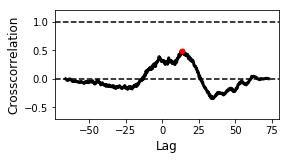

In [13]:
DiscAlignment(disc3, reference_disc=disc2, channel='ch0').plot_scores()

It's important to note that perturbations affecting the progenitor's expression dynamics will have adverse affects on the alignment. In these instances we have to manually align between different genotypes. Manual alignment can be done using ``Disc.apply_lag()``.

*Note that ``Disc()`` is an enhanced version of ``Cells``, so you can also do this with groups of cells. 

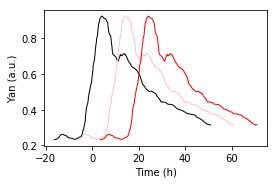

In [17]:
# load a disc 
disc = Disc.from_silhouette('data/disc1.silhouette', normalization='ch0')

# create a single figure+axis to use for all plots
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.set_ylabel('Yan (a.u.)')
ax.set_xlabel('Time (h)')

# plot the original disc
disc.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax, line_kw={'color':'black'})

# apply a 10 hour offset, then plot again
disc.apply_lag(10)
disc.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax, line_kw={'color':'pink'})

# apply another 10 hour offset, then plot again
disc.apply_lag(10)
disc.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax, line_kw={'color':'red'})

# Approach 2: Use the Experiment object

FlyEye has an ``Experiment`` object that groups related Silhouette files. 

To instantiate an Experiment, just put all the silhouette files in a single folder and tell it where that folder is. The experiment constructor lets you specify the normalization channel (e.g. DAPI), and it will also automatically align all the discs for you if you specify ``auto_alignment=True``. 

In [18]:
from flyeye.data import Experiment

# load a collection of silhouette files into a single Experiment
experiment = Experiment(
    './data', 
    normalization='ch0', 
    auto_alignment=True
)

You can check how well the alignment went using ``Experiment.get_pairwise_alignment()``. Each position in the returned vector corresponds to a disc. Each value in the vector is the average cross correlation between that disc and all the other discs. So in the example below, disc 1 has an average cross-correlation of 0.94 with discs 2 and 3.

In [20]:
experiment.get_pairwise_alignment()

array([0.94407527, 0.92770139, 0.93310191])

## Working with an Experiment object

The experiment object is intended to make life more convenient:

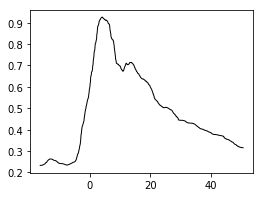

In [27]:
# you can select a single disc by simple indexing:
disc = experiment.discs[0]

fig, ax = plt.subplots(figsize=(4,3))
disc.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax)

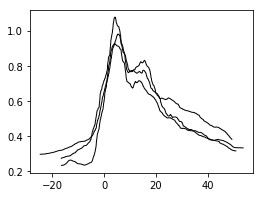

In [28]:
# or you can iterate over all the discs
fig, ax = plt.subplots(figsize=(4,3))
for disc in experiment:
    disc.select_cell_type('pre').plot_dynamics('ch2_normalized', ax=ax)

You can also simultaneously aggregate cells across all eye discs using the ``get_cells()`` method:

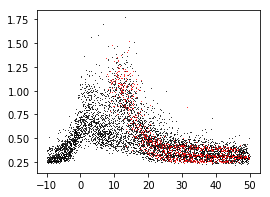

In [30]:
progenitors = experiment.get_cells(cell_type=('pre'), tmin=-10, tmax=50)
r1r6 = experiment.get_cells(cell_type=('r1','r6'), tmin=-10, tmax=50)

fig, ax = plt.subplots(figsize=(4,3))
progenitors.plot_dynamics('ch1_normalized', scatter=True, average=False, ax=ax)
r1r6.plot_dynamics('ch1_normalized', scatter=True, average=False, marker_kw={'color':'r'}, ax=ax)

``get_cells()`` returns a ``flyeye.Cells`` instance, so you can access the underlying data via pandas:

In [31]:
progenitors.data.head(3)

centroid_x  centroid_y      ch0  ch0_std      ch1  ch1_normalized  \
2667 -247.730136     891.614  132.589  32.5672  48.4604        0.365493   
1047 -261.310000    1067.520  111.160  34.8418  27.5676        0.247999   
3057 -246.384136     767.881  119.150  34.0432  44.9219        0.377020   

      ch1_normalized_flux  ch1_normalized_flux_raw  ch1_normalized_residuals  \
2667             0.075528                -0.075528                 -0.029860   
1047             0.067234                -0.067234                 -0.017876   
3057             0.046845                -0.046845                 -0.018529   

      ch1_normalized_trend    ...     ch2_normalized_residuals  \
2667              0.395353    ...                     0.020741   
1047              0.265875    ...                     0.088027   
3057              0.395549    ...                    -0.032489   

      ch2_normalized_trend  ch2_std  disc_id  label  layer  pixel_count  \
2667              0.362571  29.4434        1    pre     40          593   
1047              0.243686  21.9321        0    pre     20         1191   
3057              0.362771  24.3167        1    pre     46          640   

                                                segment  segment_id         t  
2667  [[403, 456], [399, 461], [399, 463], [397, 466...         961 -9.980314  
1047  [[1708, 414], [1700, 418], [1698, 420], [1695,...        1124 -9.942145  
3057  [[399, 578], [397, 579], [395, 582], [394, 584...         660 -9.926088  

[3 rows x 25 columns]

## Aligning multiple experiments

You can also align multiple experiments (e.g. Wildtype vs Perturbation) using the ``Experiment.apply_lag`` method, which works the same way as ``Disc.apply_lag`` does.